# Veri Analizi Dönem Projesi: Akciğer Kanseri Tahmini (Classification)

Bu projede Kaggle’dan alınan anket verisi kullanılarak **LUNG_CANCER (YES/NO)** sınıflandırma problemi çözülmüştür.
Adımlar: Veri keşfi (EDA), ön işleme, modelleme, değerlendirme ve yorumlama.


In [ ]:
!pip -q install pandas numpy matplotlib scikit-learn

## 1) Kütüphaneler ve Ayarlar


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, RocCurveDisplay
)

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)


## 2) Veri Okuma ve İlk İnceleme


In [ ]:
import pandas as pd

data_path = "survey_lung_cancer.csv"

df = pd.read_csv(data_path)
df.head()


,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,MALE,69,0,1,1,0,0,1,0,1,1,1,1,1,1,YES
1,MALE,74,1,0,0,0,1,1,1,0,0,0,1,1,1,YES
2,FEMALE,59,0,0,0,1,0,1,0,1,0,1,1,0,1,NO
3,MALE,63,1,1,1,0,0,0,0,0,1,0,0,1,1,NO
4,FEMALE,63,0,1,0,0,0,0,0,1,0,1,1,0,0,NO


In [ ]:
data_path = "survey_lung_cancer.csv"
df = pd.read_csv(data_path)

df.columns = df.columns.str.strip().str.replace(" ", "_", regex=False)

print("Şekil (satır, sütun):", df.shape)
display(df.head())

print("\nBilgi (info):")
print(df.info())

print("\nEksik değer sayıları:")
print(df.isna().sum().sort_values(ascending=False))


Şekil (satır, sütun): (309, 16)


,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC_DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL_CONSUMING,COUGHING,SHORTNESS_OF_BREATH,SWALLOWING_DIFFICULTY,CHEST_PAIN,LUNG_CANCER
0,MALE,69,0,1,1,0,0,1,0,1,1,1,1,1,1,YES
1,MALE,74,1,0,0,0,1,1,1,0,0,0,1,1,1,YES
2,FEMALE,59,0,0,0,1,0,1,0,1,0,1,1,0,1,NO
3,MALE,63,1,1,1,0,0,0,0,0,1,0,0,1,1,NO
4,FEMALE,63,0,1,0,0,0,0,0,1,0,1,1,0,0,NO



Bilgi (info):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   GENDER                 309 non-null    object
 1   AGE                    309 non-null    int64 
 2   SMOKING                309 non-null    int64 
 3   YELLOW_FINGERS         309 non-null    int64 
 4   ANXIETY                309 non-null    int64 
 5   PEER_PRESSURE          309 non-null    int64 
 6   CHRONIC_DISEASE        309 non-null    int64 
 7   FATIGUE                309 non-null    int64 
 8   ALLERGY                309 non-null    int64 
 9   WHEEZING               309 non-null    int64 
 10  ALCOHOL_CONSUMING      309 non-null    int64 
 11  COUGHING               309 non-null    int64 
 12  SHORTNESS_OF_BREATH    309 non-null    int64 
 13  SWALLOWING_DIFFICULTY  309 non-null    int64 
 14  CHEST_PAIN             309 non-null    int64 
 15  LUNG_CAN

## 3) Ön İşleme (Encoding / Dönüşümler)
- Hedef değişken: LUNG_CANCER (YES/NO) → (1/0)
- Cinsiyet: GENDER (MALE/FEMALE) → (1/0)
- Tüm özellikler numerik forma çevrilmiştir.


In [ ]:
df["LUNG_CANCER"] = (
    df["LUNG_CANCER"].astype(str).str.strip().str.upper()
    .map({"YES": 1, "NO": 0})
)

df["GENDER"] = (
    df["GENDER"].astype(str).str.strip().str.upper()
    .map({"MALE": 1, "FEMALE": 0, "M": 1, "F": 0})
)

df = df.dropna(subset=["LUNG_CANCER"]).copy()

feature_cols = [c for c in df.columns if c != "LUNG_CANCER"]
for c in feature_cols:
    vals = set(pd.to_numeric(df[c], errors="coerce").dropna().unique().tolist())
    if len(vals) > 0 and vals.issubset({1, 2}):
        df[c] = pd.to_numeric(df[c], errors="coerce").map({1: 0, 2: 1})

print("GENDER dağılımı:")
print(df["GENDER"].value_counts(dropna=False))

print("\nTarget dağılımı:")
print(df["LUNG_CANCER"].value_counts(dropna=False))


GENDER dağılımı:
GENDER
1    162
0    147
Name: count, dtype: int64

Target dağılımı:
LUNG_CANCER
1    270
0     39
Name: count, dtype: int64


## 4) EDA (Veri Keşfi ve Görselleştirme)
- Target dağılımı
- Yaş dağılımı
- Target’a göre bazı değişkenlerin ortalamaları


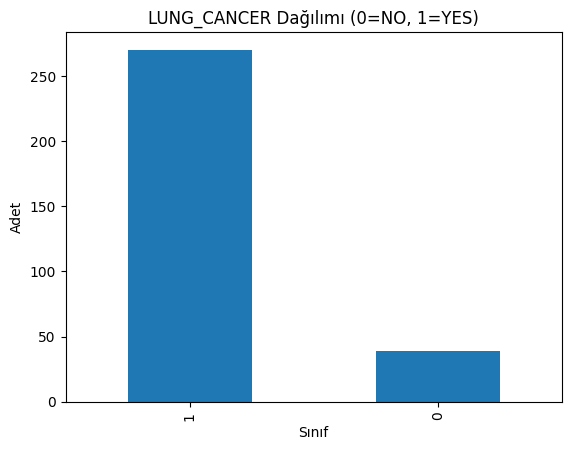

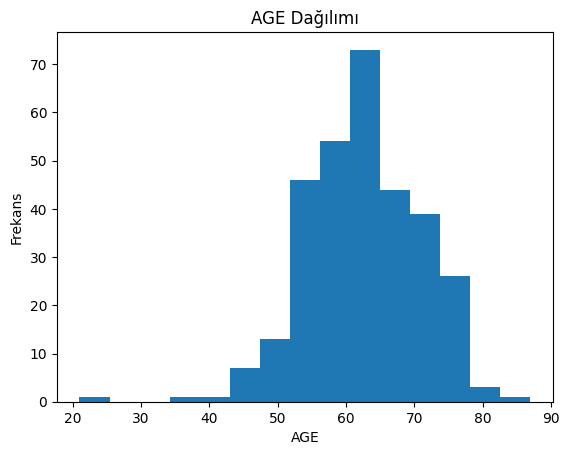

In [ ]:
target_counts = df["LUNG_CANCER"].value_counts()

plt.figure()
target_counts.plot(kind="bar")
plt.title("LUNG_CANCER Dağılımı (0=NO, 1=YES)")
plt.xlabel("Sınıf")
plt.ylabel("Adet")
plt.show()

plt.figure()
df["AGE"].plot(kind="hist", bins=15)
plt.title("AGE Dağılımı")
plt.xlabel("AGE")
plt.ylabel("Frekans")
plt.show()


,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC_DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL_CONSUMING,COUGHING,SHORTNESS_OF_BREATH,SWALLOWING_DIFFICULTY,CHEST_PAIN
LUNG_CANCER,,,,,,,,,,,,,
0,0.487179,0.333333,0.307692,0.256410,0.358974,0.487179,0.128205,0.230769,0.179487,0.256410,0.564103,0.128205,0.307692
1,0.574074,0.603704,0.525926,0.537037,0.525926,0.700000,0.618519,0.603704,0.611111,0.625926,0.651852,0.518519,0.592593


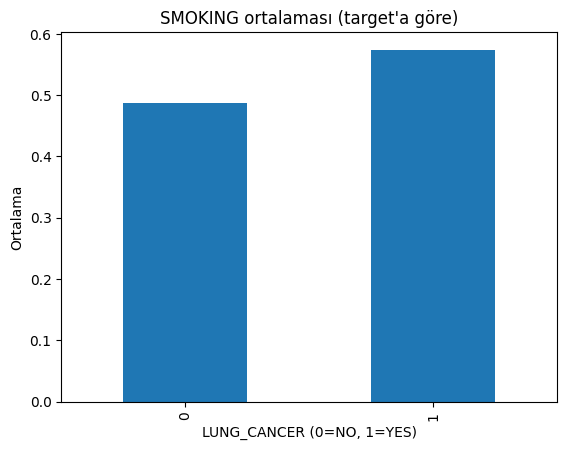

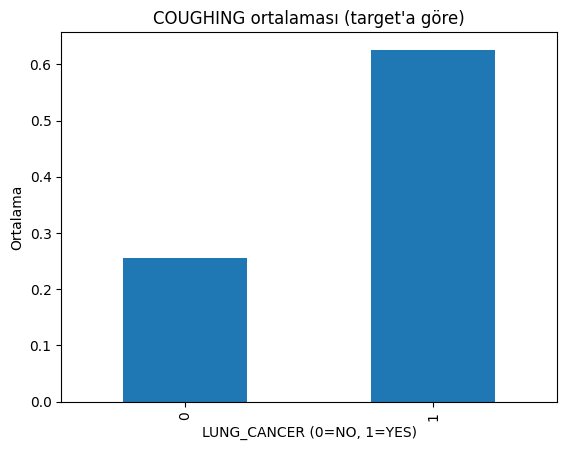

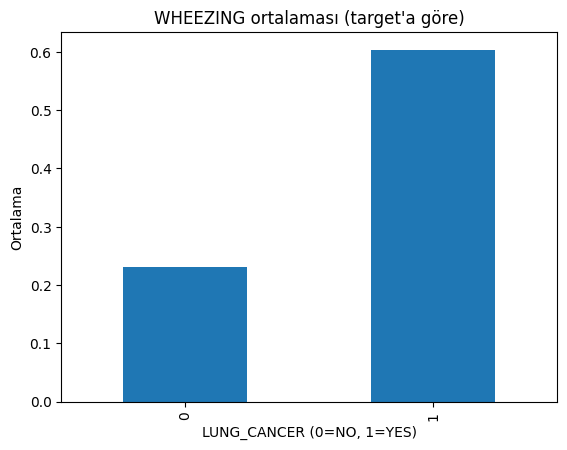

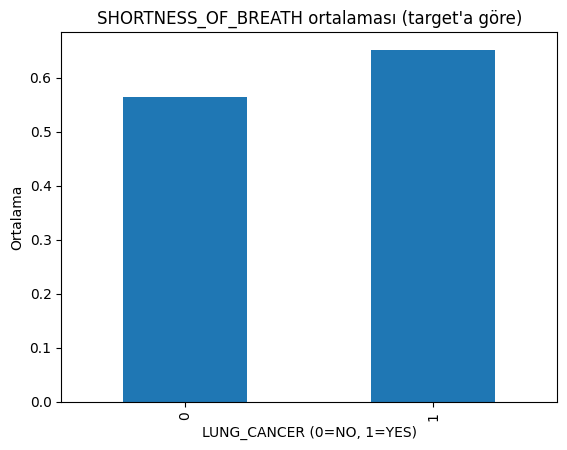

In [ ]:
candidate_cols = [
    "SMOKING","YELLOW_FINGERS","ANXIETY","PEER_PRESSURE","CHRONIC_DISEASE",
    "FATIGUE","ALLERGY","WHEEZING","ALCOHOL_CONSUMING","COUGHING",
    "SHORTNESS_OF_BREATH","SWALLOWING_DIFFICULTY","CHEST_PAIN"
]
candidate_cols = [c for c in candidate_cols if c in df.columns]

display(df.groupby("LUNG_CANCER")[candidate_cols].mean())

for c in ["SMOKING", "COUGHING", "WHEEZING", "SHORTNESS_OF_BREATH"]:
    if c in df.columns:
        plt.figure()
        df.groupby("LUNG_CANCER")[c].mean().plot(kind="bar")
        plt.title(f"{c} ortalaması (target'a göre)")
        plt.xlabel("LUNG_CANCER (0=NO, 1=YES)")
        plt.ylabel("Ortalama")
        plt.show()


## 5) Aykırı Değer Analizi (AGE)
IQR yöntemi ile AGE değişkeni için aykırı değerler kontrol edilmiştir.


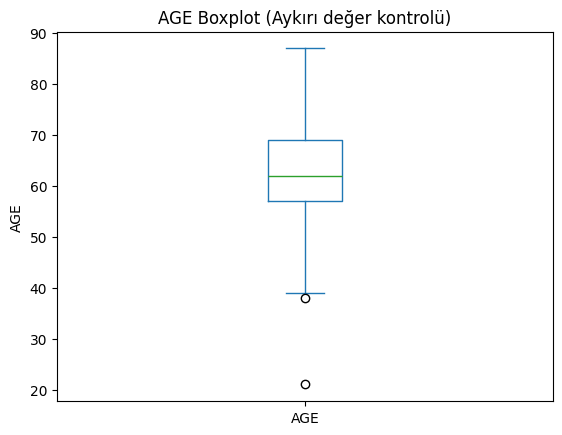

AGE IQR sınırları: lower=39.00, upper=87.00
AGE aykırı değer sayısı: 2


In [ ]:
plt.figure()
df["AGE"].plot(kind="box")
plt.title("AGE Boxplot (Aykırı değer kontrolü)")
plt.ylabel("AGE")
plt.show()

age = df["AGE"]
q1, q3 = age.quantile(0.25), age.quantile(0.75)
iqr = q3 - q1
lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
outliers = age[(age < lower) | (age > upper)]

print(f"AGE IQR sınırları: lower={lower:.2f}, upper={upper:.2f}")
print("AGE aykırı değer sayısı:", outliers.shape[0])


## 6) Modelleme için Veri Hazırlama + Korelasyon
Tüm özellikler numerik hale getirilmiştir ve korelasyon matrisi görselleştirilmiştir.


Toplam NaN: 0


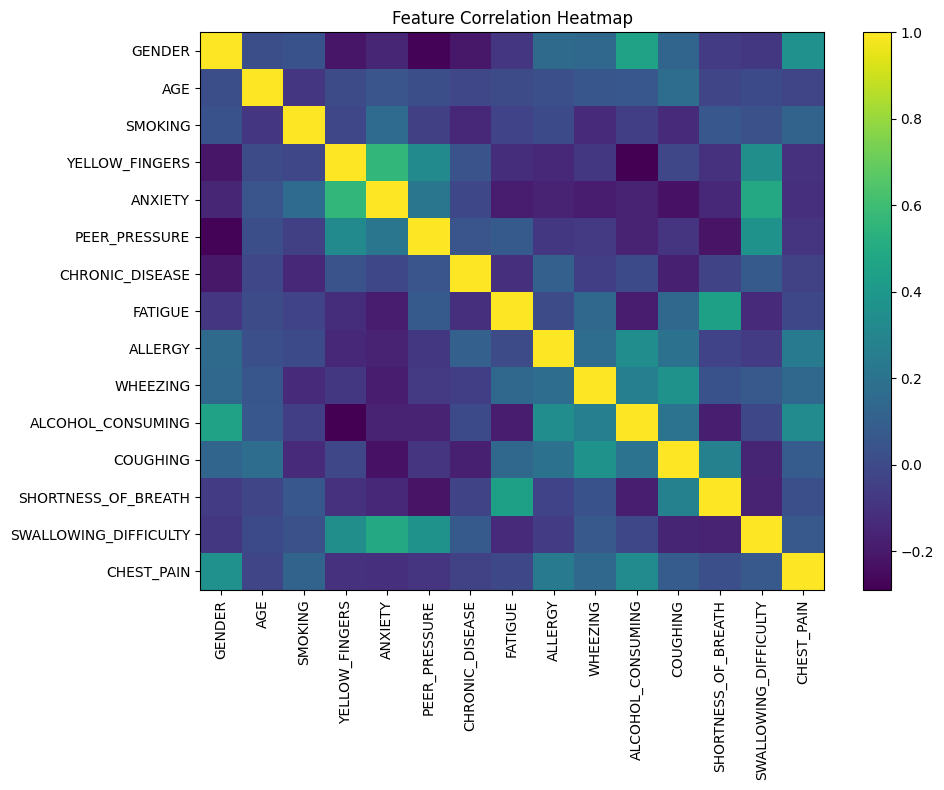

In [ ]:
X = df.drop(columns=["LUNG_CANCER"]).apply(pd.to_numeric, errors="coerce")
y = df["LUNG_CANCER"].astype(int)

print("Toplam NaN:", int(X.isna().sum().sum()))

corr = X.corr()
plt.figure(figsize=(10, 8))
plt.imshow(corr, aspect="auto")
plt.title("Feature Correlation Heatmap")
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.tight_layout()
plt.show()


## 7) Train/Test Split
Veri seti %80 eğitim, %20 test olarak bölünmüştür (stratify=y).


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (247, 15) Test: (62, 15)


## 8) Model 1: Logistic Regression (Baseline)
Eksik değerler için median imputation ve ölçekleme uygulanmıştır.


--- Logistic Regression ---
Accuracy: 0.8709677419354839
ROC-AUC: 0.9537037037037037
Confusion Matrix:
 [[ 8  0]
 [ 8 46]]

Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         8
           1       1.00      0.85      0.92        54

    accuracy                           0.87        62
   macro avg       0.75      0.93      0.79        62
weighted avg       0.94      0.87      0.89        62



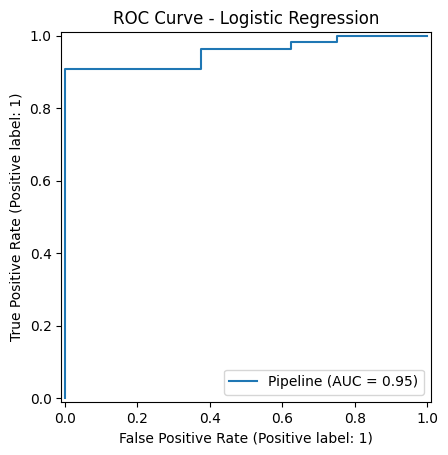

In [ ]:
log_reg = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

log_reg.fit(X_train, y_train)
pred_lr = log_reg.predict(X_test)
proba_lr = log_reg.predict_proba(X_test)[:, 1]

print("--- Logistic Regression ---")
print("Accuracy:", accuracy_score(y_test, pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, proba_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, pred_lr))
print("\nClassification Report:\n", classification_report(y_test, pred_lr))

RocCurveDisplay.from_estimator(log_reg, X_test, y_test)
plt.title("ROC Curve - Logistic Regression")
plt.show()


## 9) Model 2: Random Forest + Feature Importance
Model performansı metriklerle değerlendirilmiş ve en önemli değişkenler incelenmiştir.


--- Random Forest ---
Accuracy: 0.8870967741935484
ROC-AUC: 0.9456018518518519
Confusion Matrix:
 [[ 4  4]
 [ 3 51]]

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.50      0.53         8
           1       0.93      0.94      0.94        54

    accuracy                           0.89        62
   macro avg       0.75      0.72      0.73        62
weighted avg       0.88      0.89      0.88        62



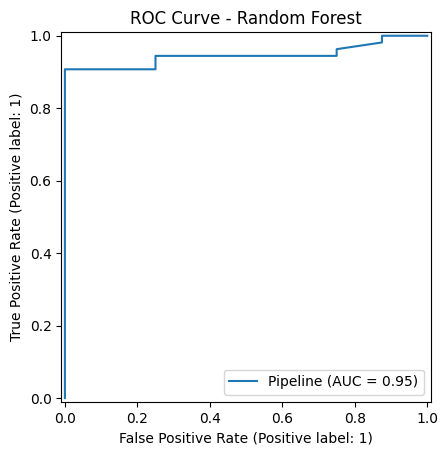


En önemli değişkenler (ilk 10):


,0
AGE,0.150282
ALLERGY,0.128379
ALCOHOL_CONSUMING,0.107537
PEER_PRESSURE,0.081174
FATIGUE,0.067246
WHEEZING,0.061691
SWALLOWING_DIFFICULTY,0.058966
COUGHING,0.056040
YELLOW_FINGERS,0.054187
CHRONIC_DISEASE,0.051075


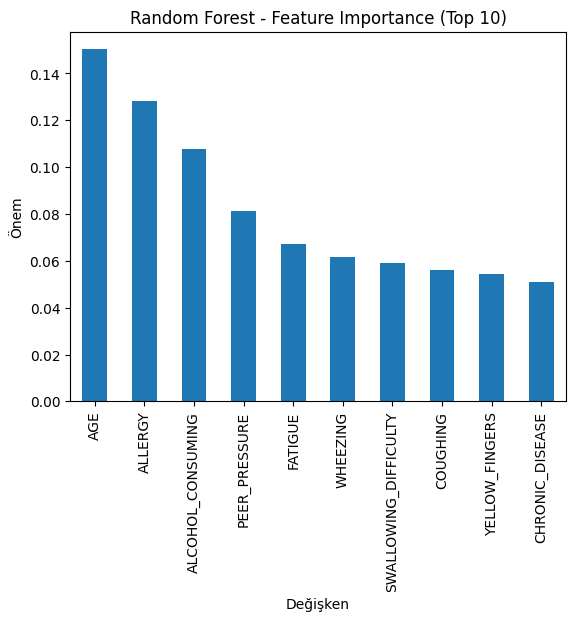

In [ ]:
rf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", RandomForestClassifier(
        n_estimators=300, random_state=42, class_weight="balanced"
    ))
])

rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
proba_rf = rf.predict_proba(X_test)[:, 1]

print("--- Random Forest ---")
print("Accuracy:", accuracy_score(y_test, pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, proba_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, pred_rf))
print("\nClassification Report:\n", classification_report(y_test, pred_rf))

RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.title("ROC Curve - Random Forest")
plt.show()

rf_model = rf.named_steps["model"]
feature_names = rf.named_steps["imputer"].get_feature_names_out(X.columns)
importances = pd.Series(rf_model.feature_importances_, index=feature_names).sort_values(ascending=False)

print("\nEn önemli değişkenler (ilk 10):")
display(importances.head(10))

plt.figure()
importances.head(10).plot(kind="bar")
plt.title("Random Forest - Feature Importance (Top 10)")
plt.xlabel("Değişken")
plt.ylabel("Önem")
plt.show()


## 10) Sonuç Özeti
Veri dengesiz olduğu için (YES çok fazla, NO az) Accuracy yanında Confusion Matrix ve F1-score da yorumlanmıştır.


In [ ]:
print("Sınıf dağılımı:\n", df["LUNG_CANCER"].value_counts())
print("\nLogReg Accuracy:", accuracy_score(y_test, pred_lr), "ROC-AUC:", roc_auc_score(y_test, proba_lr))
print("RF Accuracy:", accuracy_score(y_test, pred_rf), "ROC-AUC:", roc_auc_score(y_test, proba_rf))


Sınıf dağılımı:
 LUNG_CANCER
1    270
0     39
Name: count, dtype: int64

LogReg Accuracy: 0.8709677419354839 ROC-AUC: 0.9537037037037037
RF Accuracy: 0.8870967741935484 ROC-AUC: 0.9456018518518519
